In [513]:
import pickle 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
import gym 
import energym 

In [321]:
def nice_plot(save_df, file_name):
    import seaborn as sns
    import matplotlib.dates as mdates
    from matplotlib.ticker import MaxNLocator
    sns.set(style="whitegrid", font_scale=1.5)

    save_df_week = save_df.loc[datetime.datetime(2015, 7, 11, 0):datetime.datetime(2015, 7, 15, 1)]
    soc = save_df_week['soc']
    power_bid = save_df_week['power_bid']
    power_cleared = save_df_week['power_cleared']
    ref_price = save_df_week['ref_price']
    price_bid = save_df_week['price_bid']
    price_cleared = save_df_week['price_cleared']

    reward = save_df_week['reward']

    fig, ax1 = plt.subplots(figsize=(13, 5))

    power_bid.plot(kind='bar', ax=ax1, align='edge', width=1, color='xkcd:silver', edgecolor='black')
    power_cleared.plot(kind='bar', ax=ax1, align='edge', width=1, color='xkcd:blue', edgecolor='black')

    ax1.xaxis.set_major_locator(MaxNLocator(10))
    ax1.set_xticklabels(date_sticks_2, rotation=50)
    ax1.set_ylim([-1000, 1400])
    plt.legend(['power bid (MW)', 'power cleared (MW)'], bbox_to_anchor=(0.3, -0.6), loc=2, borderaxespad=0.)
    plt.ylabel('power (MW)')

    ax2 = ax1.twinx()

    # soc.plot(kind='line', ax=ax1, use_index=False, stacked=False, color='xkcd:turquoise')
    # ref_price.plot(kind='line', ax=ax, use_index=False, stacked=False, color='xkcd:lightblue')
    price_bid.plot(kind='line', ax=ax2, use_index=False, stacked=False, color='xkcd:red')
    price_cleared.plot(kind='line', ax=ax2, use_index=False, stacked=False, color='xkcd:black')
    # reward.plot(kind='line', ax=ax, use_index=False, stacked=False, color='xkcd:red')

    ax2.set_ylabel('', color='r')
    ax2.tick_params('y', colors='r')
    ax2.set_ylim([10, 100])

    plt.legend()
    plt.ylabel('price ($/MWh)')
    plt.legend(['price bid', 'price cleared'], bbox_to_anchor=(0, -0.6), loc=2, borderaxespad=0.)
    plt.savefig(file_name + '.png', dpi=100, bbox_inches='tight')

In [697]:
def compute_percentage_error(save_df):
    num_not_safe = 0
    total_setps = 0
    env = gym.make('battery-v0')
    
    for i in range(len(save_df['reward'].values)):
        power_bid = save_df['power_bid'].iloc[i]
        try:
            soc = save_df['soc'].iloc[i]
        except:
            soc = save_df['soe'].iloc[i]
        reward = save_df['reward'].iloc[i]
#         energy_to_add = - env._efficiency_ratio * power_bid
#         next_soe = soc + energy_to_add
        if not (-2 <= soc - power_bid*0.99 <= 3000 and -1000 < power_bid < 1000):
            num_not_safe += 1
        total_setps += 1
    percent_not_safe = num_not_safe * 100 / total_setps
    print(percent_not_safe)

In [699]:
def add_columns(save_df):
    power_real_charge = []
    power_real_discharge = []
    print(len(save_df['reward'].values))
    for i, price_bid in enumerate(save_df['power_bid'].values):
        power_bid = save_df['power_bid'].iloc[i]
        try:
            soc = save_df['soc'].iloc[i]
        except:
            soc = save_df['soe'].iloc[i]
        reward = save_df['reward'].iloc[i]
        if -2 <= soc - power_bid*0.99 <= 3000 and -1000 < power_bid < 1000:
            if power_bid >= 0:
                power_real_charge.append(0)
                power_real_discharge.append(power_bid)
            else:
                power_real_charge.append(power_bid)
                power_real_discharge.append(0)
        else:
            power_real_charge.append(0)
            power_real_discharge.append(0)
    
    save_df['power_real_charge'] = power_real_charge
    save_df['power_real_discharge'] = power_real_discharge

In [645]:
with open('results/dqn_mpc.pkl', 'rb') as pickle_file:
        save_dict = pickle.load(pickle_file)
save_dict['price_cleared'] = [0] + save_dict['price_cleared']

In [646]:
save_df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in save_dict.items() ]))
save_df = save_df.set_index('date')

In [647]:
compute_percentage_error(save_df)

32.663989290495316


/Users/mathildebadoual/miniconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [648]:
add_columns(save_df)

In [649]:
save_df.head()

,power_bid,price_bid,soc,power_cleared,reward,price_cleared,ref_price,power_dqn,cost_dqn,power_real_charge,power_real_discharge
date,,,,,,,,,,,
2015-06-01 19:00:00+00:00,0.000000,0.000000,1270.964355,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
2015-06-01 19:00:00+00:00,-133.332389,30.918242,1402.963421,-133.332389,-5455.727005,0.000000,30.923816,-133.333333,-10.0,-133.332389,0.0
2015-06-01 20:00:00+00:00,-133.332389,38.918242,1534.962486,-133.332389,-5832.050970,40.918242,34.695639,-133.333333,-2.0,-133.332389,0.0
2015-06-01 21:00:00+00:00,-133.332630,33.740692,1666.961790,-133.332630,-6286.163407,43.740692,39.865137,-133.333333,-10.0,-133.332630,0.0
2015-06-01 22:00:00+00:00,-133.332747,37.146474,1798.961209,-133.332747,-6879.957288,47.146474,43.908788,-133.333333,-10.0,-133.332747,0.0


In [650]:
dates = pd.date_range(start=datetime.datetime(2015, 7, 11, 0), end=datetime.datetime(2015, 7, 15, 1), freq=pd.DateOffset(hours=5)).values
dates_xticks = np.datetime_as_string(dates).tolist()
dates_xticks

['2015-07-11T00:00:00.000000000',
 '2015-07-11T05:00:00.000000000',
 '2015-07-11T10:00:00.000000000',
 '2015-07-11T15:00:00.000000000',
 '2015-07-11T20:00:00.000000000',
 '2015-07-12T01:00:00.000000000',
 '2015-07-12T06:00:00.000000000',
 '2015-07-12T11:00:00.000000000',
 '2015-07-12T16:00:00.000000000',
 '2015-07-12T21:00:00.000000000',
 '2015-07-13T02:00:00.000000000',
 '2015-07-13T07:00:00.000000000',
 '2015-07-13T12:00:00.000000000',
 '2015-07-13T17:00:00.000000000',
 '2015-07-13T22:00:00.000000000',
 '2015-07-14T03:00:00.000000000',
 '2015-07-14T08:00:00.000000000',
 '2015-07-14T13:00:00.000000000',
 '2015-07-14T18:00:00.000000000',
 '2015-07-14T23:00:00.000000000']

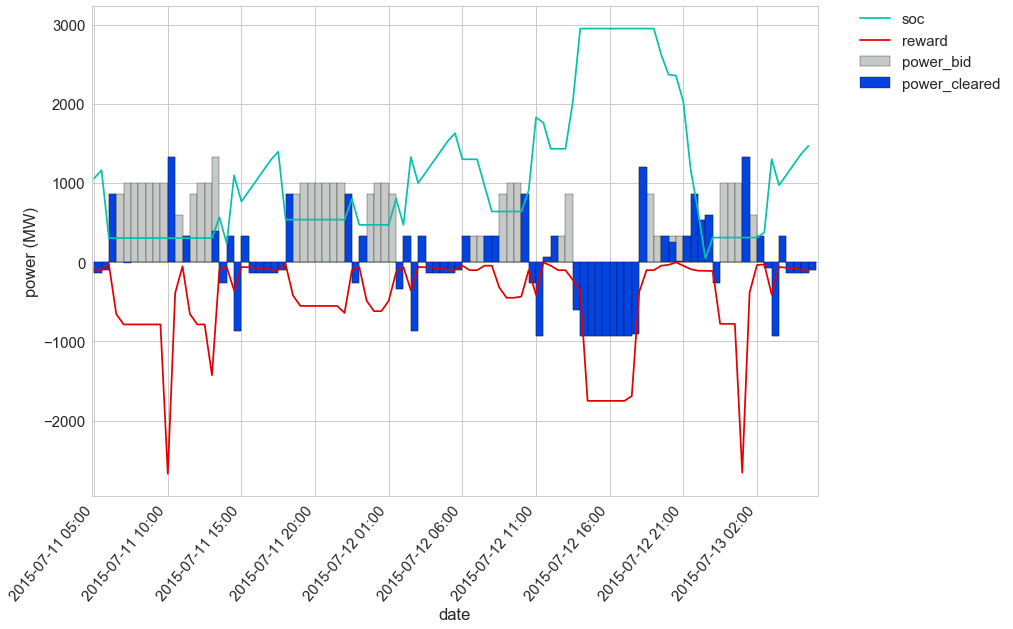

In [651]:
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
sns.set(style="whitegrid", font_scale=1.5)

save_df_week = save_df.loc[datetime.datetime(2015, 7, 11, 0):datetime.datetime(2015, 7, 15, 1)]
soc = save_df_week['soc']
power_bid = save_df_week['power_bid']
power_cleared = save_df_week['power_cleared']
ref_price = save_df_week['ref_price']*10
price_bid = save_df_week['price_bid']*10
price_cleared = save_df_week['price_cleared']*10
power_dqn = save_df_week['power_dqn']
# power_expert = save_df_week['power_expert']
# price_bid_expert = save_df_week['price_bid_expert']
# power_bid_expert = save_df_week['power_bid_expert']
# price_bid_dqn = save_df_week['price_bid_dqn']
# power_bid_dqn = save_df_week['power_bid_dqn']
reward = save_df_week['reward']*0.01

fig, ax = plt.subplots(figsize=(13, 10))

soc.plot(kind='line', ax=ax, use_index=False, stacked=False, color='xkcd:turquoise')
# ref_price.plot(kind='area', ax=ax, use_index=False, stacked=False, color='xkcd:lightblue')
# price_bid.plot(kind='line', ax=ax, use_index=False, stacked=False, color='xkcd:blue')
# price_cleared.plot(kind='line', ax=ax, use_index=False, stacked=False, color='xkcd:black')
# price_bid_dqn.plot(kind='line', ax=ax, use_index=False, stacked=False, color='xkcd:green')
reward.plot(kind='line', ax=ax, use_index=False, stacked=False, color='xkcd:red')

# power_dqn.plot(kind='bar', ax=ax, align='edge', width=1, color='xkcd:red', edgecolor='black')
# power_expert.plot(kind='bar', ax=ax, align='edge', width=1, color='xkcd:orange', edgecolor='black')
power_bid.plot(kind='bar', ax=ax, align='edge', width=1, color='xkcd:silver', edgecolor='black')
power_cleared.plot(kind='bar', ax=ax, align='edge', width=1, color='xkcd:blue', edgecolor='black')

ax.xaxis.set_major_locator(MaxNLocator(10))
ax.set_xticklabels(date_sticks_2, rotation=50)
plt.legend()
plt.ylabel('power (MW)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('mpc_dqn_bids.png', dpi=100, bbox_inches='tight')

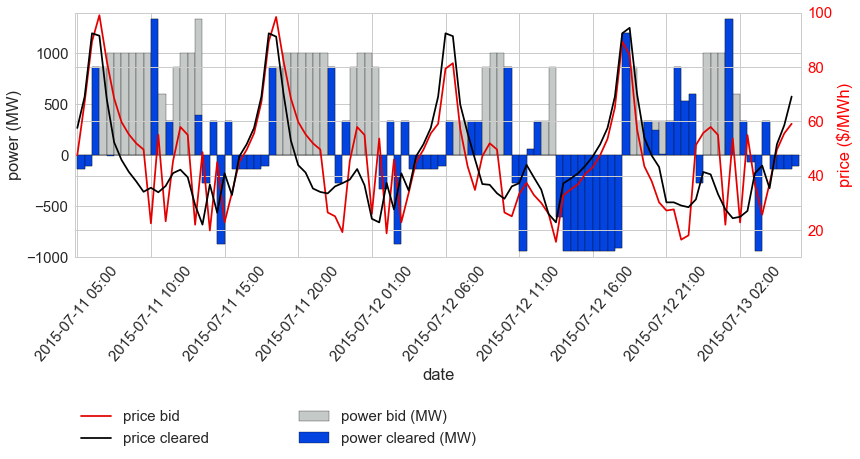

In [652]:
nice_plot(save_df, 'mpc_dqn_bids')

In [653]:
df_optim_alone = pd.read_csv('results/expert_alone.csv')
# df_optim_alone['time_step'].loc[0] = '2015-06-01 19:00:00+00:00'
f = lambda x: datetime.datetime.strptime(x, '%m/%d/%y %H:%M')
df_optim_alone['time_step'] = df_optim_alone['time_step'].apply(f)

df_optim_alone = df_optim_alone.rename(columns={'time_step': 'date'})

df_optim_alone = df_optim_alone.set_index('date')
df_optim_alone.head()

,Unnamed: 0,soe,power_cleared,price_bid,reward,done,power_bid,price_cleared,power_bid_dqn,power_bid_expert,price_bid_dqn,price_bid_expert
date,,,,,,,,,,,,
2015-06-01 07:00:00,0,1270.964355,0.000000,0.000000,0.00000,0,0.000000,0.000000,0,0.000000,0,0.000000
2015-06-01 08:00:00,1,2260.964253,-999.999897,40.918242,-39954.56946,FALSE,-999.999897,39.954574,0,-999.999897,0,40.918242
2015-06-01 09:00:00,2,2999.999877,-746.500630,40.918242,-28114.16578,FALSE,-746.500630,37.661275,0,-746.500630,0,40.918242
2015-06-01 10:00:00,3,2999.999877,-0.000019,40.918242,-50.00000,FALSE,-0.000019,36.521682,0,-0.000019,0,40.918242
2015-06-01 11:00:00,4,2999.999877,-0.000019,40.918242,-50.00000,FALSE,-0.000019,36.118017,0,-0.000019,0,40.918242


In [667]:
add_columns(df_optim_alone)

In [702]:
compute_percentage_error(df_optim_alone)

/Users/mathildebadoual/miniconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


3738
4.280363830925629


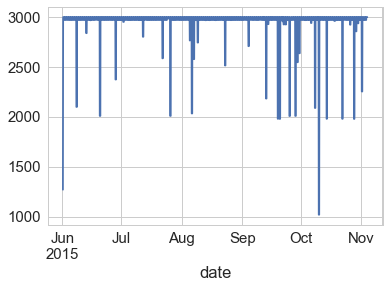

In [669]:
df_optim_alone['soe'].plot()

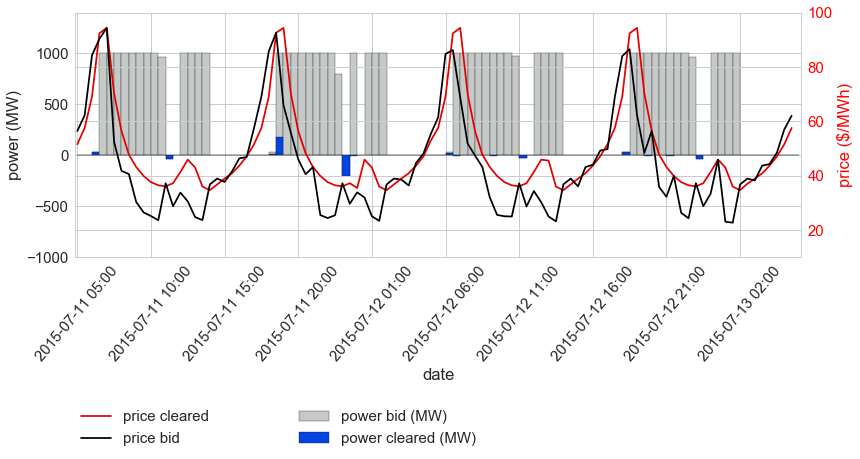

In [670]:
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
sns.set(style="whitegrid", font_scale=1.5)

save_df_week = df_optim_alone.loc[datetime.datetime(2015, 7, 11, 0):datetime.datetime(2015, 7, 15, 1)]
soc = save_df_week['soe'] * 0.07
power_bid = save_df_week['power_bid']
power_cleared = save_df_week['power_cleared']
price_bid = save_df_week['price_bid']
price_cleared = save_df_week['price_cleared']

reward = save_df_week['reward']

fig, ax1 = plt.subplots(figsize=(13, 5))

power_bid.plot(kind='bar', ax=ax1, align='edge', width=1, color='xkcd:silver', edgecolor='black')
power_cleared.plot(kind='bar', ax=ax1, align='edge', width=1, color='xkcd:blue', edgecolor='black')

ax1.xaxis.set_major_locator(MaxNLocator(10))
ax1.set_xticklabels(date_sticks_2, rotation=50)
ax1.set_ylim([-1000, 1400])
plt.legend(['power bid (MW)', 'power cleared (MW)'], bbox_to_anchor=(0.3, -0.6), loc=2, borderaxespad=0.)
plt.ylabel('power (MW)')

ax2 = ax1.twinx()

# soc.plot(kind='line', ax=ax2, use_index=False, stacked=False, color='xkcd:turquoise')
price_bid.plot(kind='line', ax=ax2, use_index=False, stacked=False, color='xkcd:red')
price_cleared.plot(kind='line', ax=ax2, use_index=False, stacked=False, color='xkcd:black')
# reward.plot(kind='line', ax=ax, use_index=False, stacked=False, color='xkcd:red')

ax2.set_ylabel('', color='r')
ax2.tick_params('y', colors='r')
ax2.set_ylim([10, 100])

plt.legend()
plt.ylabel('price ($/MWh)')
plt.legend(['price cleared', 'price bid'], bbox_to_anchor=(0, -0.6), loc=2, borderaxespad=0.)
plt.savefig('mpc_only_bids.png', dpi=100, bbox_inches='tight')

In [680]:
# 12_19_23_38_try_dqn_simple.pkl.pkl
with open('results/26_16_17_42_test_dqn_only.pkl', 'rb') as pickle_file:
        save_dict_dqn_only = pickle.load(pickle_file)
save_df_dqn_only = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in save_dict_dqn_only.items() ]))
# save_df_dqn_only = save_df_dqn_only.dropna()
save_df_dqn_only = save_df_dqn_only.set_index('date')

In [688]:
with open('results/26_15_50_4_test_dqn_shield.pkl', 'rb') as pickle_file:
        save_dict_dqn_shield = pickle.load(pickle_file)
save_df_dqn_shield = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in save_dict_dqn_shield.items() ]))
# save_df_dqn_only = save_df_dqn_only.dropna()
save_df_dqn_shield = save_df_dqn_shield.set_index('date')

In [689]:
add_columns(save_df_dqn_only)
add_columns(save_df_dqn_shield)

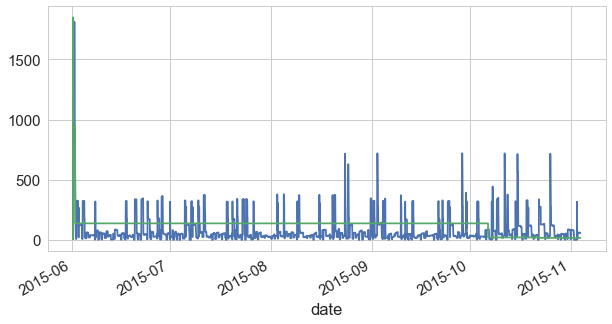

In [690]:
save_df_dqn_only.head()
save_df_dqn_only['soc'].plot(figsize=(10,5))
save_df_dqn_shield['soc'].plot(figsize=(10,5))

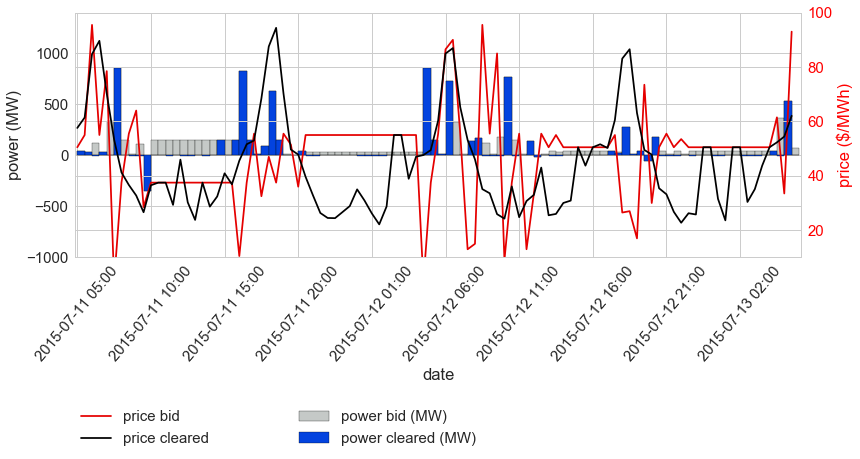

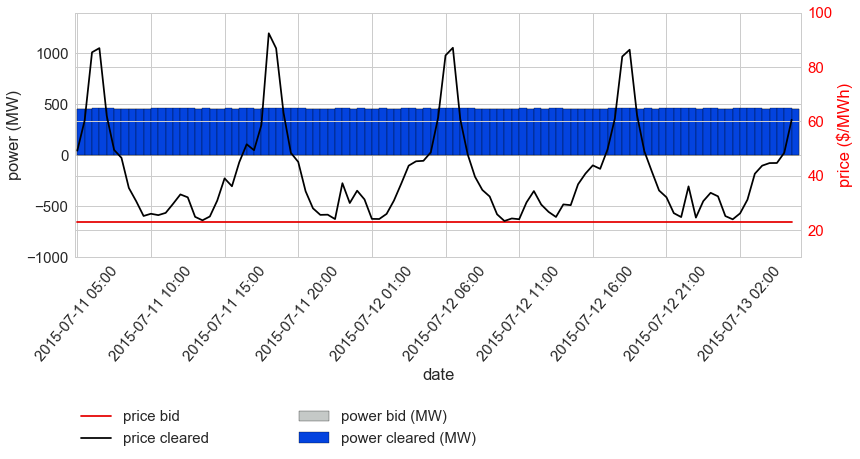

In [695]:
nice_plot(save_df_dqn_only, 'dqn_only_bids')
nice_plot(save_df_dqn_shield, 'dqn_shield_bids')

In [701]:
compute_percentage_error(save_df_dqn_only)
compute_percentage_error(save_df_dqn_shield)

/Users/mathildebadoual/miniconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


3739
41.240973522332176
3739
99.70580369082643


In [693]:
def compute_revenue(save_df):
    revenue = save_df['power_real_discharge'].values * save_df['price_bid'].values + save_df['power_real_charge'].values * save_df['price_cleared'].values
    revenue = revenue[~np.isnan(revenue)]
    print(np.sum(revenue))

In [700]:
compute_revenue(df_optim_alone)
compute_revenue(save_df)
compute_revenue(save_df_dqn_only)
compute_revenue(save_df_dqn_shield)

106217613.12507531
8652167.461161865
4031200.710948591
256070.9085282609
